In [1]:
!pip install scikit-image tqdm


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
%%bash
kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown



100%|██████████| 312M/312M [00:00<00:00, 491MB/s]


In [4]:
!unzip brain-tumor-segmentation.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.filters import threshold_sauvola
from skimage.morphology import remove_small_objects, remove_small_holes
from sklearn.metrics import jaccard_score


In [7]:
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)


In [8]:
def preprocess(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img


In [9]:
def postprocess(mask):
    mask = mask.astype(bool)
    mask = remove_small_objects(mask, min_size=500)
    mask = remove_small_holes(mask, area_threshold=500)
    return mask.astype(np.uint8)


In [11]:
DATASET_PATH = "/content/"

image_dir = os.path.join(DATASET_PATH, "images")
mask_dir = os.path.join(DATASET_PATH, "masks")

image_files = sorted(os.listdir(image_dir))

dice_otsu = []
dice_sauvola = []

jaccard_otsu = []
jaccard_sauvola = []

for file in tqdm(image_files):

    # Read image
    img_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or gt is None:
        continue

    gt = (gt > 127).astype(np.uint8)

    img = preprocess(img)

    # -------- OTSU --------
    _, otsu_mask = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    otsu_mask = (otsu_mask > 0).astype(np.uint8)
    otsu_mask = postprocess(otsu_mask)

    # -------- SAUVOLA --------
    window_size = 25
    thresh_sauvola = threshold_sauvola(img, window_size=window_size, k=0.3)
    sauvola_mask = img > thresh_sauvola
    sauvola_mask = postprocess(sauvola_mask)

    # -------- Metrics --------
    dice_otsu.append(dice_score(gt, otsu_mask))
    dice_sauvola.append(dice_score(gt, sauvola_mask))

    jaccard_otsu.append(
        jaccard_score(gt.flatten(), otsu_mask.flatten())
    )
    jaccard_sauvola.append(
        jaccard_score(gt.flatten(), sauvola_mask.flatten())
    )

100%|██████████| 3064/3064 [02:59<00:00, 17.03it/s]


In [12]:
print("===== AVERAGE RESULTS =====")

print(f"Otsu Dice: {np.mean(dice_otsu):.4f}")
print(f"Sauvola Dice: {np.mean(dice_sauvola):.4f}")

print(f"Otsu Jaccard: {np.mean(jaccard_otsu):.4f}")
print(f"Sauvola Jaccard: {np.mean(jaccard_sauvola):.4f}")


===== AVERAGE RESULTS =====
Otsu Dice: 0.0706
Sauvola Dice: 0.0455
Otsu Jaccard: 0.0376
Sauvola Jaccard: 0.0237


In [13]:
def visualize_sample(index=10):
    file = image_files[index]

    img = cv2.imread(os.path.join(image_dir, file), cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(os.path.join(mask_dir, file), cv2.IMREAD_GRAYSCALE)
    gt = (gt > 127).astype(np.uint8)

    img_p = preprocess(img)

    _, otsu_mask = cv2.threshold(
        img_p, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    otsu_mask = postprocess(otsu_mask > 0)

    thresh_sauvola = threshold_sauvola(img_p, window_size=25, k=0.3)
    sauvola_mask = postprocess(img_p > thresh_sauvola)

    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(otsu_mask, cmap='gray')
    plt.title("Otsu Result")
    plt.axis("off")

    plt.subplot(2,2,4)
    plt.imshow(sauvola_mask, cmap='gray')
    plt.title("Sauvola Result")
    plt.axis("off")

    plt.show()


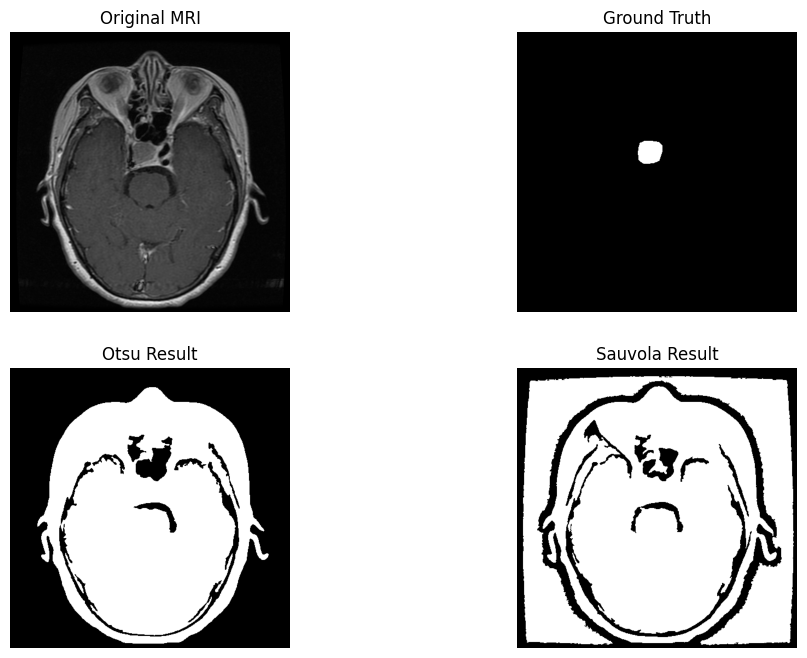

In [14]:
visualize_sample(20)
